In [1]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

C:\Users\Alex Vogt\AppData\Local\Programs\Python\Python36\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 6
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [6]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CUDA Available:  False


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:

epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.371851  [    0/60000]


C:\Users\Alex Vogt\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.271594  [ 6400/60000]
loss: 2.022966  [12800/60000]
loss: 1.571283  [19200/60000]
loss: 1.110567  [25600/60000]
loss: 0.983823  [32000/60000]
loss: 1.006886  [38400/60000]
loss: 0.721677  [44800/60000]
loss: 0.717591  [51200/60000]
loss: 0.761637  [57600/60000]
Epoch 2
-------------------------------
loss: 0.544061  [    0/60000]
loss: 0.785124  [ 6400/60000]
loss: 0.731310  [12800/60000]
loss: 0.420542  [19200/60000]
loss: 0.577693  [25600/60000]
loss: 0.393296  [32000/60000]
loss: 0.451141  [38400/60000]
loss: 0.388598  [44800/60000]
loss: 0.564039  [51200/60000]
loss: 0.415227  [57600/60000]
Epoch 3
-------------------------------
loss: 0.514894  [    0/60000]
loss: 0.385397  [ 6400/60000]
loss: 0.555294  [12800/60000]
loss: 0.404189  [19200/60000]
loss: 0.438489  [25600/60000]
loss: 0.443254  [32000/60000]
loss: 0.435240  [38400/60000]
loss: 0.406224  [44800/60000]
loss: 0.499427  [51200/60000]
loss: 0.362186  [57600/60000]
Epoch 4
-------------------------------
loss: 0.44

In [9]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [11]:
def test( model, device, test_loader, epsilon, realValue):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if realValue == 1:
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == init_pred.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [12]:
accuracies = []
examples = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies.append(acc)
    examples.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9657 / 10000 = 0.9657
Epsilon: 0.05	Test Accuracy = 9154 / 10000 = 0.9154
Epsilon: 0.1	Test Accuracy = 8135 / 10000 = 0.8135
Epsilon: 0.15	Test Accuracy = 6271 / 10000 = 0.6271
Epsilon: 0.2	Test Accuracy = 3682 / 10000 = 0.3682
Epsilon: 0.25	Test Accuracy = 1672 / 10000 = 0.1672
Epsilon: 0.3	Test Accuracy = 615 / 10000 = 0.0615


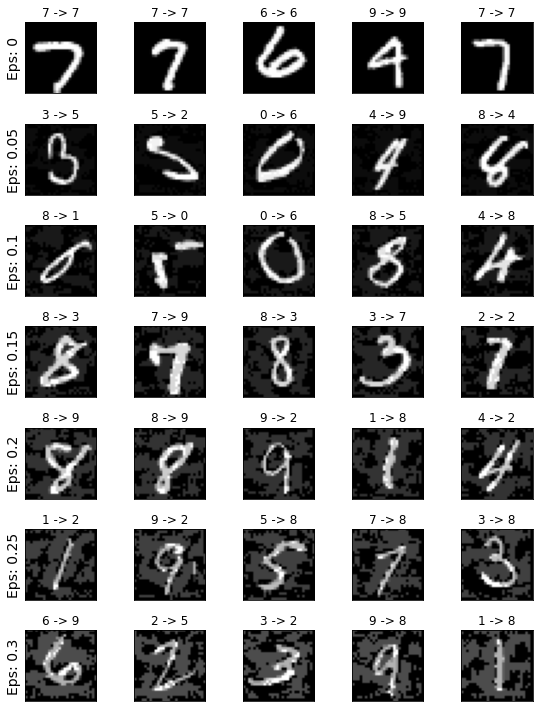

In [16]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig,adv,ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

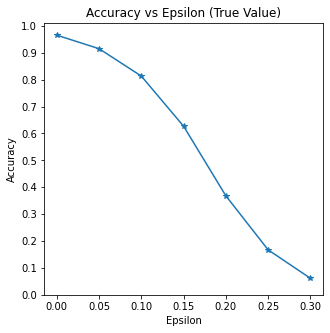

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [18]:
accuracies2 = []
examples2 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies2.append(acc)
    examples2.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9473 / 10000 = 0.9473
Epsilon: 0.1	Test Accuracy = 8425 / 10000 = 0.8425
Epsilon: 0.15	Test Accuracy = 6539 / 10000 = 0.6539
Epsilon: 0.2	Test Accuracy = 3932 / 10000 = 0.3932
Epsilon: 0.25	Test Accuracy = 1898 / 10000 = 0.1898
Epsilon: 0.3	Test Accuracy = 818 / 10000 = 0.0818


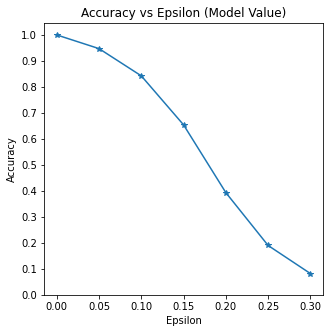

In [20]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()